In [26]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [27]:
# Create an ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    vertical_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2,         # Randomly zoom images (range: 0.2 means 20% zoom in/out)
    shear_range=0.2        # Randomly shear images
)

# Load your dataset using tf.keras.utils.image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory('photos')

# Create lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# Loop through each batch of data
for images, labels in data:
    # Loop through each image in the batch
    for i in range(len(images)):
        image_np = images[i].numpy()  # Convert TensorFlow tensor to NumPy array
        augmented_images.append(image_np)  # Original image
        augmented_labels.append(labels[i])

        # Apply data augmentation multiple times (e.g., 3 times)
        for _ in range(5):
            augmented_image = datagen.random_transform(image_np)
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

# Convert lists to NumPy arrays and normalize
augmented_images = np.array(augmented_images) / 255.0
augmented_labels = np.array(augmented_labels)

# Create a new dataset with augmented data
augmented_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Shuffle the dataset and set batch size
augmented_data = augmented_data.shuffle(len(augmented_images))


Found 507 files belonging to 2 classes.


In [28]:
num_images = len(augmented_images)
num_classes = len(np.unique(augmented_labels))
print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

Number of images: 3042
Number of classes: 2


In [29]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [32]:
num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True)

# Lists to store metrics for each fold
acc_per_fold = []
loss_per_fold = []

histories = []

fold_no = 1
for train, val in kfold.split(X_train, y_train):
    # Split data
    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size= 64, callbacks=[early_stopping, lr_schedule])
    
    # Save the history to plot later
    histories.append(history)
    
    fold_no += 1

Epoch 1/20
26/26 [==============================] - 12s 442ms/step - loss: 0.6593 - accuracy: 0.5999 - val_loss: 0.6138 - val_accuracy: 0.6732 - lr: 1.0000e-04
Epoch 2/20
26/26 [==============================] - 11s 432ms/step - loss: 0.5714 - accuracy: 0.7145 - val_loss: 0.5464 - val_accuracy: 0.7090 - lr: 1.1220e-04
Epoch 3/20
26/26 [==============================] - 12s 456ms/step - loss: 0.4874 - accuracy: 0.7836 - val_loss: 0.4552 - val_accuracy: 0.8039 - lr: 1.2589e-04
Epoch 4/20
26/26 [==============================] - 13s 506ms/step - loss: 0.4320 - accuracy: 0.8083 - val_loss: 0.5135 - val_accuracy: 0.7694 - lr: 1.4125e-04
Epoch 5/20
26/26 [==============================] - 14s 558ms/step - loss: 0.3926 - accuracy: 0.8126 - val_loss: 0.4175 - val_accuracy: 0.8200 - lr: 1.5849e-04
Epoch 6/20
26/26 [==============================] - 12s 463ms/step - loss: 0.3331 - accuracy: 0.8631 - val_loss: 0.3618 - val_accuracy: 0.8385 - lr: 1.7783e-04
Epoch 7/20
26/26 [======================

In [33]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

20/20 - 1s - loss: 0.2010 - accuracy: 0.9261 - 1s/epoch - 60ms/step
Test accuracy: 0.9261083602905273


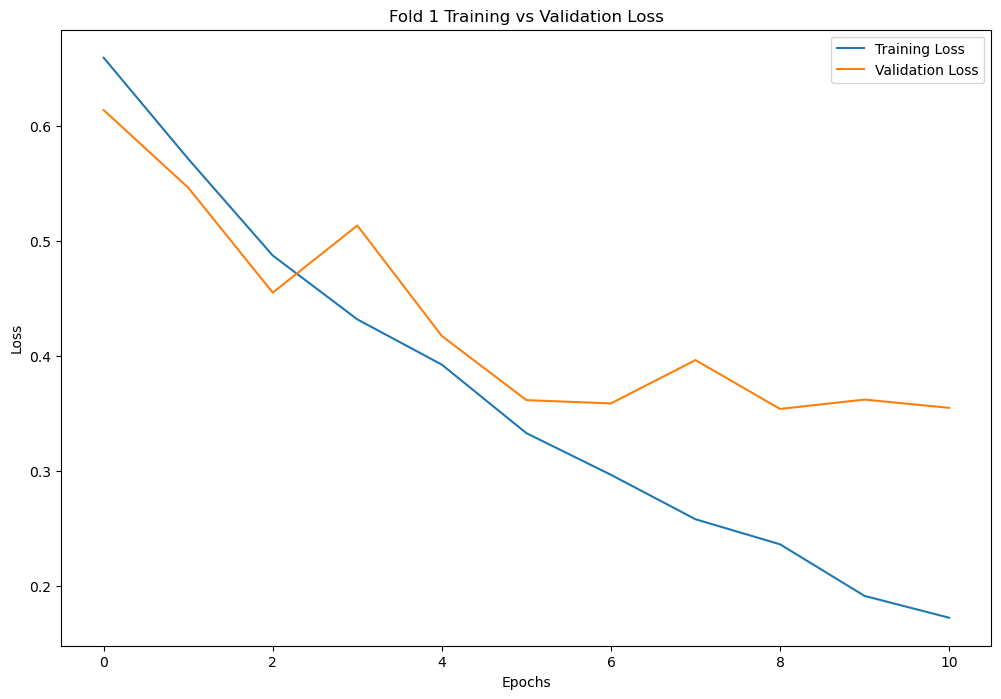

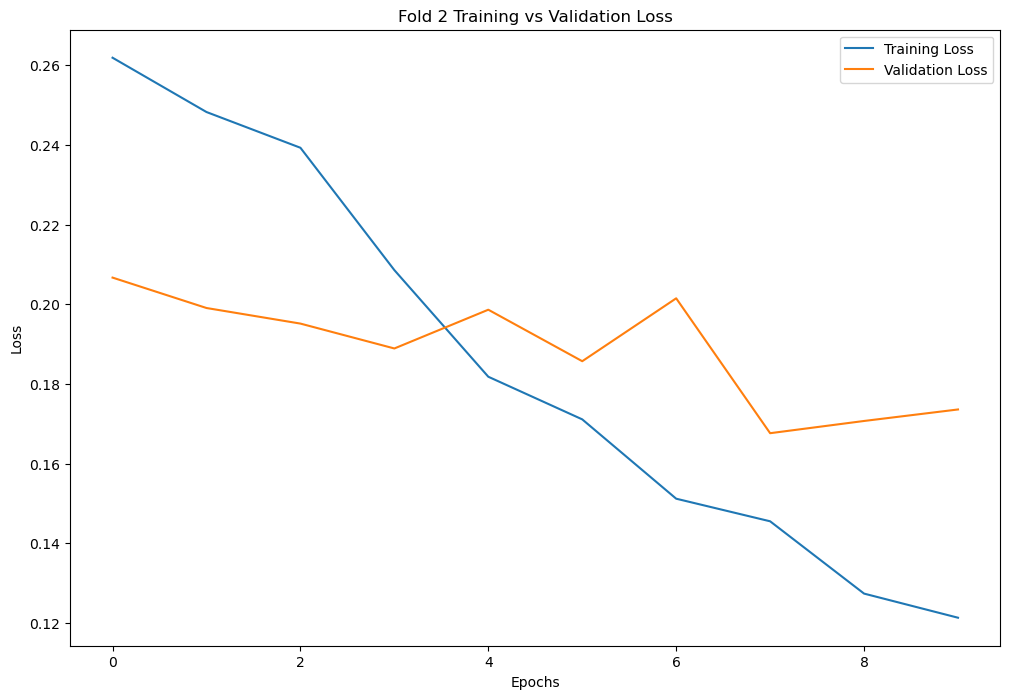

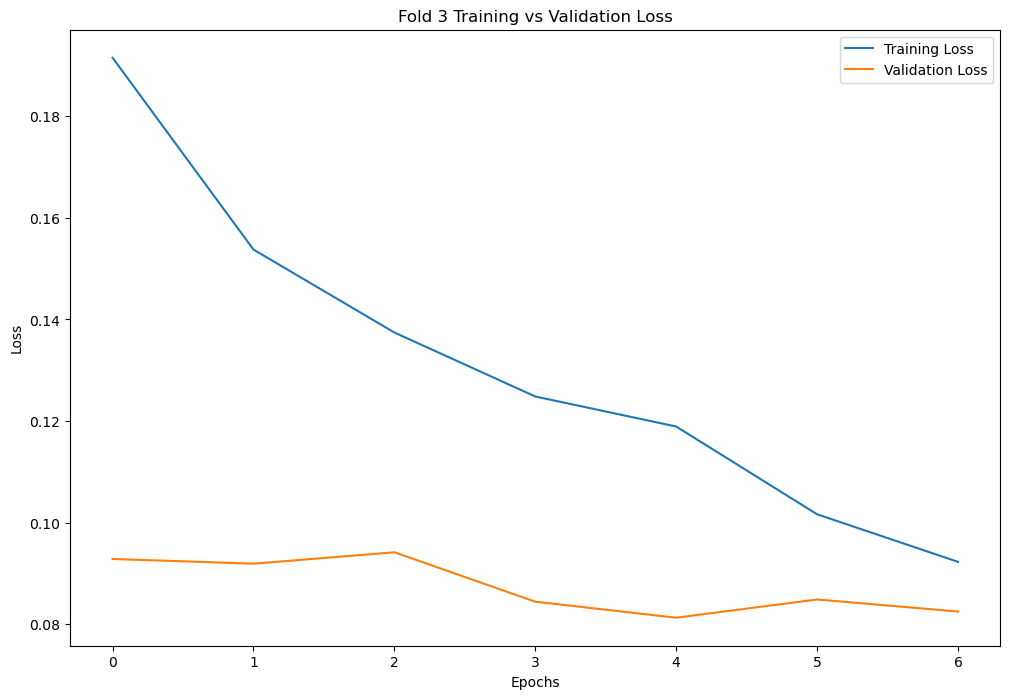

In [34]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i+1} Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [35]:
model.save("classification_model.h5")

E:\Code\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
